**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip install tensorflow
!pip insatll wordcloud
!pip insatll nltk

ERROR: unknown command "insatll" - maybe you meant "install"
ERROR: unknown command "insatll" - maybe you meant "install"


In [3]:
# Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [6]:
#importing tensorflow libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import nltk, re, collections, pickle, os # nltk - Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

import warnings
warnings.filterwarnings(action = "ignore")
warnings.simplefilter(action = 'ignore', category = Warning)
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

# %matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')
seed = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
#importing libraries for modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
spam = pd.read_csv('spam.csv',encoding = 'latin-1')

In [9]:
spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [10]:
#dropping the unnecessary column
to_drop = ['Unnamed: 2','Unnamed: 3','Unnamed: 4']
spam = spam.drop(spam[to_drop],axis = 1)

In [11]:
#Renaming the column
spam.rename(columns = {'v1':'Target','v2':'Text'},inplace = True )
spam.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
# checking duplicate
spam.drop_duplicates(inplace = True,ignore_index = True)
print('Number of null values : \n')
spam.isnull().sum()

Number of null values : 



Target    0
Text      0
dtype: int64

In [13]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5169 non-null   object
 1   Text    5169 non-null   object
dtypes: object(2)
memory usage: 80.9+ KB


**Data Exploration**

Text(0, 0.5, 'Number of Data Points')

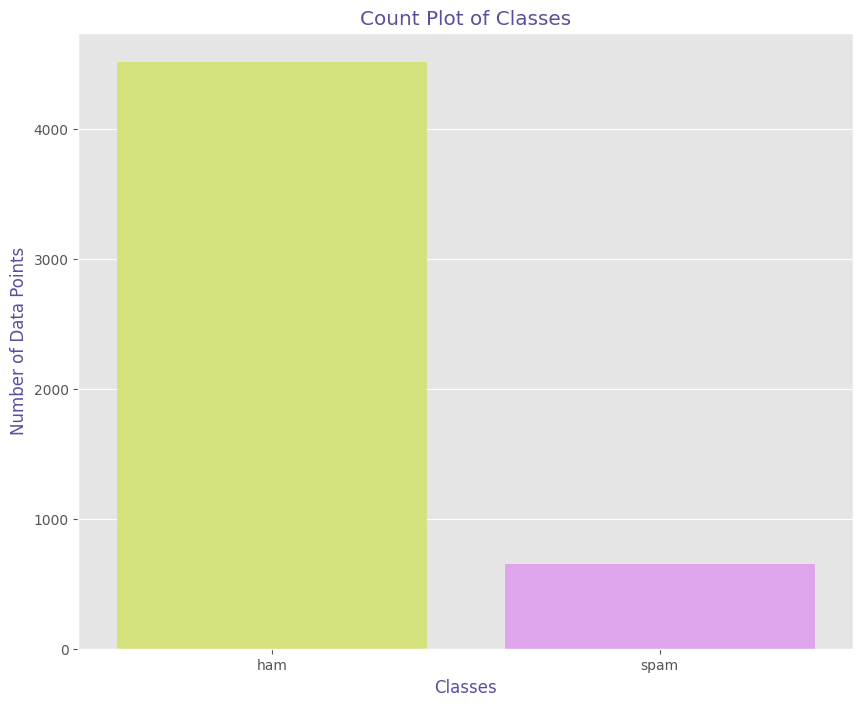

In [14]:
#selecting palette
cols = ['#E1F26E','#E599F8']
plt.figure(figsize = (10,8))
fig = sns.countplot(x=spam['Target'],palette = cols)
fig.set_title('Count Plot of Classes',color = '#58509d')
fig.set_xlabel('Classes',color = '#58509d')
fig.set_ylabel('Number of Data Points',color = '#58509d')

**Conclusion:** Number of ham e-mails are more than spam

**Feature Engineering**

In [15]:
# adding a column
spam['No_of_Char'] =     spam['Text'].apply(len)
spam['No_of_words'] =    spam.apply(lambda row : nltk.word_tokenize(row['Text']),axis = 1).apply(len)
spam['No_of_sentence'] = spam.apply(lambda row : nltk.sent_tokenize(row['Text']),axis =1).apply(len)
spam.head()

,Target,Text,No_of_Char,No_of_words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [16]:
spam.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Char,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,910.0
No_of_words,5169.0,18.455794,13.324758,1.0,9.0,15.0,26.0,220.0
No_of_sentence,5169.0,1.965564,1.448541,1.0,1.0,1.0,2.0,38.0


<Figure size 1200x800 with 0 Axes>

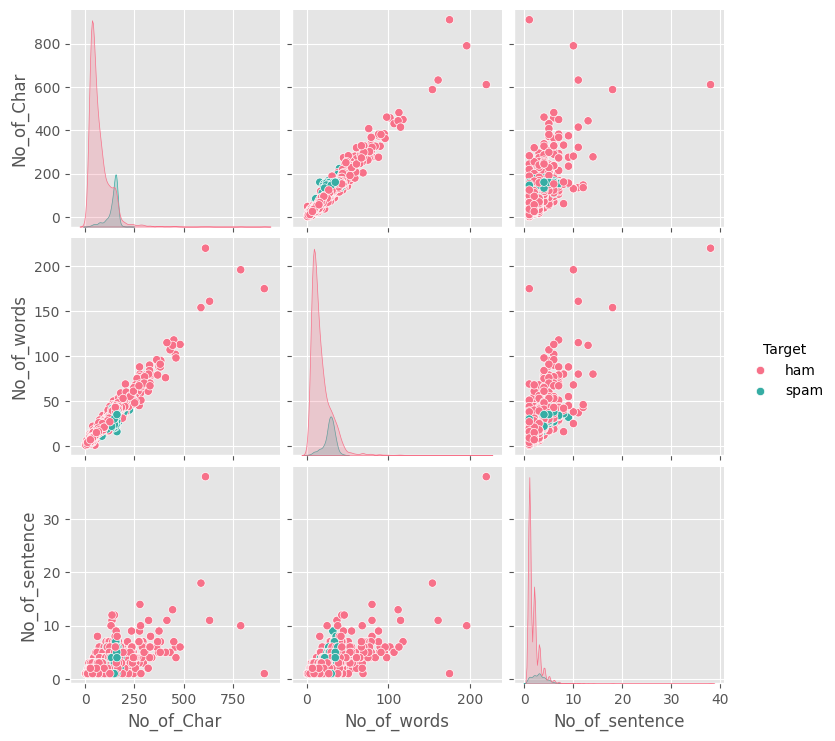

In [17]:
sns.color_palette("husl", 9)
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=spam, hue="Target",palette='husl')
plt.show(fg)

**Conclusion:** There are outliers in all class of ham. Should drop outliers.I should drop outliers.

In [18]:
#dropping outliers
spam = spam[(spam['No_of_Char']< 350)]
spam.shape

(5149, 5)

<Figure size 1200x800 with 0 Axes>

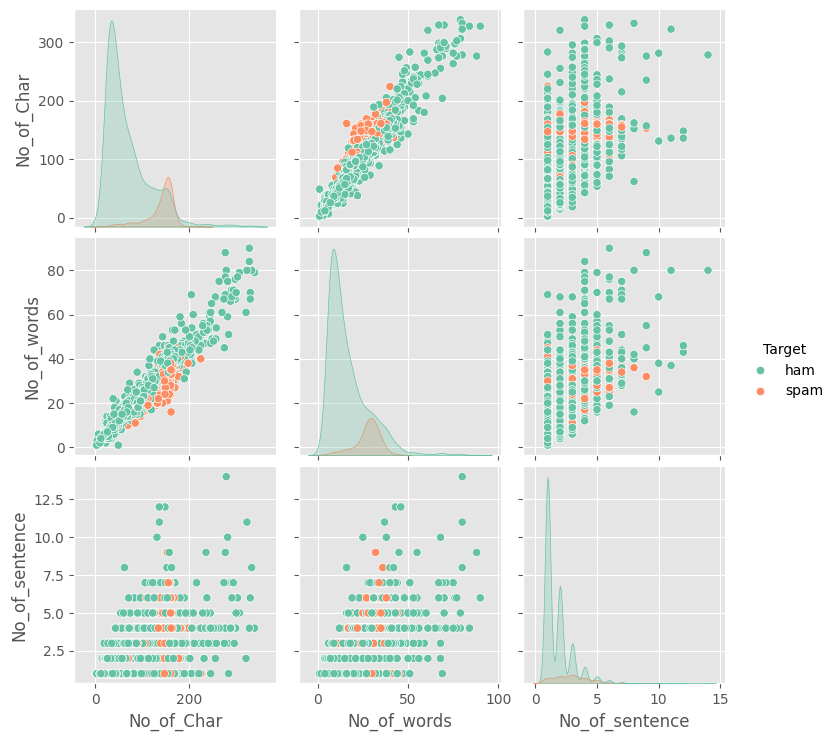

In [19]:
#again checking if there are any outliers
sns.color_palette("Set2")
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=spam, hue="Target",palette='Set2')
plt.show(fg)

**Conclusion:** Cleaned the Outliers

**Data Cleaning**

In [20]:
# looking into data
print('\030[1m\u001b[45;1m The First 5 Texts : \030[0m',*spam['Text'][:5],sep = '\n')

 The First 5 Texts : 
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


There are so many ..... in every statement

In [21]:
# defining the function to clean up data
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text)
    sms = sms.lower()
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

In [22]:
spam['Clean_Text'] = spam['Text'].apply(Clean)


In [23]:
#let us have look into same data
print('\033[1m\u001b[45;1m The First 5 Texts : \033[0m',*spam['Clean_Text'][:5],sep = '\n')

 The First 5 Texts : 
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


**Tokenization**

Tokenization is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words. I am splitting the Clean_Text into words at this step.

In [24]:
spam['Tokenization_text'] = spam.apply(lambda row : nltk.word_tokenize(row['Clean_Text']),axis = 1)

spam.head()

,Target,Text,No_of_Char,No_of_words,No_of_sentence,Clean_Text,Tokenization_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,..."


In [25]:
# looking into same data

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*spam["Tokenization_text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


**Removing Stopwords**

In [26]:
#function for writting stopwords

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

In [27]:
spam["Nostopword_Text"] = spam["Tokenization_text"].apply(remove_stopwords)

In [28]:
#looking into same data
print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*spam["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


Stopwords are frequently occurring words(such as few, is, an, etc). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing.

**Lemmatization**

Stemming is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

lemmatization also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English.

In [ ]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

df_spam["Lemmatized_Text"] = df_spam["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*df_spam["Lemmatized_Text"][:5], sep = "\n")

In [30]:
lemmatizer = WordNetLemmatizer()
# function for lemmatizing string
def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word,pos = 'v') for word in text]
    return lemmas

In [31]:
spam ['Lemmatized_Text'] = spam['Nostopword_Text'].apply(lemmatize_word)

In [32]:
#looking into data
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*spam['Lemmatized_Text'][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


**Vectorization**

TF-IDF in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents) Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.

In [33]:
# creating a corpus of text
corpus = []
for i in spam['Lemmatized_Text']:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]

['go jurong point crazy available bugis n great world la e buffet cine get amore wat',
 'ok lar joke wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf live around though']

In [34]:
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Changing text data in to numbers.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature
X.dtype

dtype('float64')

In [36]:
from sklearn.preprocessing import LabelEncoder
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
spam ['Target'] = label_encoder.fit_transform(spam['Target'])

**Data Modelling**

In [38]:
#Setting values for labels and features as y & x(x is already converted into vector)
y = spam['Target']
#splitting the testing & Training sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

Model-1 MultinomialNB

In [41]:
#create & train the Multi Naive BAyes Classifier
clf_MNB = MultinomialNB()
clf_MNB.fit(X_train,y_train)

MultinomialNB()

In [42]:
print(clf_MNB.score(X_train,y_train))
print(y_train.values)

0.9737800436999272
[0 0 0 ... 0 0 0]


In [43]:
#Evaluate the model
from sklearn.metrics import accuracy_score
pred_MNB = clf_MNB.predict(X_train)
print(classification_report(y_train,pred_MNB))
print()
print('Confusion Matrix: \n',confusion_matrix(y_train,pred_MNB))
print('Accuracy: \n',accuracy_score,(y_train,pred_MNB))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3580
           1       1.00      0.80      0.89       539

    accuracy                           0.97      4119
   macro avg       0.99      0.90      0.94      4119
weighted avg       0.97      0.97      0.97      4119


Confusion Matrix: 
 [[3580    0]
 [ 108  431]]
Accuracy: 
 <function accuracy_score at 0x7a7f5f53e050> (2644    0
99      0
2488    0
1354    0
4022    1
       ..
4445    0
467     0
3108    0
3789    0
862     0
Name: Target, Length: 4119, dtype: int64, array([0, 0, 0, ..., 0, 0, 0]))


In [44]:
#Evaluating on test model
pred_test = clf_MNB.predict(X_test)
print(classification_report(y_test, pred_test))
print()
print("Confusion Matrix: \n", confusion_matrix(y_test, pred_test))
print("Accuracy: \n", accuracy_score(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       916
           1       1.00      0.75      0.85       114

    accuracy                           0.97      1030
   macro avg       0.98      0.87      0.92      1030
weighted avg       0.97      0.97      0.97      1030


Confusion Matrix: 
 [[916   0]
 [ 29  85]]
Accuracy: 
 0.9718446601941747


**Model-2 Random Forest**

In [49]:
# create and train the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train,y_train)


RandomForestClassifier()

In [51]:
print(clf_rf.score(X_train,y_train))
print(y_train.values)

1.0
[0 0 0 ... 0 0 0]


In [53]:
# Evaluating the model on the training data set

pred_rf = clf_rf.predict(X_train)
print(classification_report(y_train, pred_rf))
print()
print("Confusion Matrix: \n", confusion_matrix(y_train, pred_rf))
print("Accuracy: \n", accuracy_score(y_train, pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3580
           1       1.00      1.00      1.00       539

    accuracy                           1.00      4119
   macro avg       1.00      1.00      1.00      4119
weighted avg       1.00      1.00      1.00      4119


Confusion Matrix: 
 [[3580    0]
 [   0  539]]
Accuracy: 
 1.0


In [54]:
# Evaluating the model on the training data set

pred_test = clf_rf.predict(X_test)
print(classification_report(y_test, pred_test))
print()
print("Confusion Matrix: \n", confusion_matrix(y_test, pred_test))
print("Accuracy: \n", accuracy_score(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       916
           1       1.00      0.85      0.92       114

    accuracy                           0.98      1030
   macro avg       0.99      0.93      0.96      1030
weighted avg       0.98      0.98      0.98      1030


Confusion Matrix: 
 [[916   0]
 [ 17  97]]
Accuracy: 
 0.983495145631068


Model-3 SVM

In [55]:
clf_svc = SVC()
clf_svc.fit(X_train,y_train)

SVC()

In [56]:
# Evaluating the model on the training data set

pred_svc = clf_svc.predict(X_train)
print(classification_report(y_train, pred_svc))
print()
print("Confusion Matrix: \n", confusion_matrix(y_train, pred_svc))
print("Accuracy: \n", accuracy_score(y_train, pred_svc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3580
           1       1.00      0.98      0.99       539

    accuracy                           1.00      4119
   macro avg       1.00      0.99      1.00      4119
weighted avg       1.00      1.00      1.00      4119


Confusion Matrix: 
 [[3580    0]
 [   9  530]]
Accuracy: 
 0.9978150036416606


In [57]:
# Evaluating the model on the testing data set

pred_test = clf_svc.predict(X_test)
print(classification_report(y_test, pred_test))
print()
print("Confusion Matrix: \n", confusion_matrix(y_test, pred_test))
print("Accuracy: \n", accuracy_score(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       916
           1       0.98      0.80      0.88       114

    accuracy                           0.98      1030
   macro avg       0.98      0.90      0.93      1030
weighted avg       0.98      0.98      0.97      1030


Confusion Matrix: 
 [[914   2]
 [ 23  91]]
Accuracy: 
 0.9757281553398058


Model-4 DecisionTree Classifier

In [63]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [64]:
# Evaluating the model on the training data set

pred_dt = clf_dt.predict(X_train)
print(classification_report(y_train, pred_dt))
print()
print("Confusion Matrix: \n", confusion_matrix(y_train, pred_dt))
print("Accuracy: \n", accuracy_score(y_train, pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3580
           1       1.00      1.00      1.00       539

    accuracy                           1.00      4119
   macro avg       1.00      1.00      1.00      4119
weighted avg       1.00      1.00      1.00      4119


Confusion Matrix: 
 [[3580    0]
 [   0  539]]
Accuracy: 
 1.0


In [65]:
# Evaluating the model on the testing data set

pred_test = clf_dt.predict(X_test)
print(classification_report(y_test, pred_test))
print()
print("Confusion Matrix: \n", confusion_matrix(y_test, pred_test))
print("Accuracy: \n", accuracy_score(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       916
           1       0.81      0.89      0.85       114

    accuracy                           0.97      1030
   macro avg       0.90      0.93      0.91      1030
weighted avg       0.97      0.97      0.97      1030


Confusion Matrix: 
 [[893  23]
 [ 13 101]]
Accuracy: 
 0.9650485436893204


**Model Comparison**

In [66]:
models = {
    'MultinomialNB' :MultinomialNB(),
    'Random Forest' : RandomForestClassifier(random_state = 42),
    'SVC':SVC(random_state = 42),
    'DecisionTreeClassifier':DecisionTreeClassifier(random_state = 42)
}

In [67]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_accuracy_score = accuracy_score(y_train, y_pred_train)
    test_accuracy_score = accuracy_score(y_test, y_pred_test)
    #train_f1 = f1_score(y_train, y_pred_train)
    #test_f1 = f1_score(y_test, y_pred_test)
    results.append({'Model': name,
                    #'Training MSE': train_mse,
                    #'Testing MSE': test_mse,
                    'Training Accuracy': train_accuracy_score,
                    'Testing Accuracy': test_accuracy_score})
results_df = pd.DataFrame(results)
results_df

,Model,Training Accuracy,Testing Accuracy
0,MultinomialNB,0.973780,0.971845
1,Random Forest,1.000000,0.981553
2,SVC,0.997815,0.975728
3,DecisionTreeClassifier,1.000000,0.963107
